<a href="https://colab.research.google.com/github/mveiyo/mveiyo/blob/main/Copy_of_pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/Muraldataset/original images1/"

# from glob import glob
# datasets = glob(dataset_path)
# datasets

In [ ]:
# https://youtu.be/UcHe0xiuvpg
# https://youtu.be/6pUSZgPJ3Yg
# https://youtu.be/my7LEgYTJto
"""
pix2pix GAN model

Based on the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/
I seriously urge everyone to foloow his blogs and get enlightened.
I am adapting his code to various applications but original credit goes to Jason.


    Original paper: https://arxiv.org/pdf/1611.07004.pdf
    Github for original paper: https://phillipi.github.io/pix2pix/


Generator:
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512-C512
decoder:
CD512-CD512-CD512-C512-C256-C128-C64


Discriminator
C64-C128-C256-C512
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
"""
#
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model


#############################################################################
#Define generator, discriminator, gan and other helper functions
#We will use functional way of defining model and not sequential
#as we have multiple inputs; both images and corresponding labels.
########################################################################

#Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label
#For pix2pix the label will be another image.

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (1 or 0). So using sigmoid activation.
#Think of discriminator as a binary classifier that is classifying images as real/fake.

# From the paper C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.

def define_discriminator(image_shape):

	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper

	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but
                                                #standalone descriminator will be trainable.

	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks.
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save("model_000300.h5")
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

Loaded:  (159, 256, 256, 3) (159, 256, 256, 3)


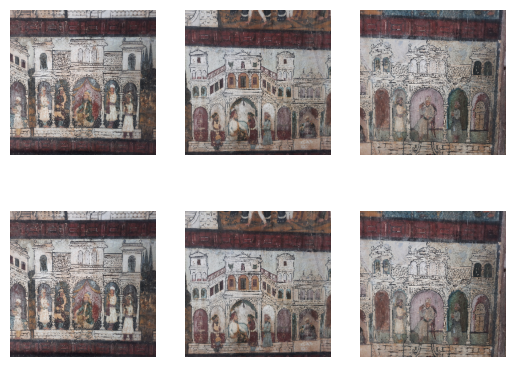

1/1 [==============================] - 1s 554ms/step
>1, d1[0.340] d2[2.751] g[40.251]
1/1 [==============================] - 0s 21ms/step
>2, d1[1.811] d2[3.221] g[27.463]
1/1 [==============================] - 0s 21ms/step
>3, d1[0.408] d2[1.177] g[38.299]
1/1 [==============================] - 0s 23ms/step
>4, d1[0.278] d2[0.676] g[23.123]
1/1 [==============================] - 0s 22ms/step
>5, d1[0.508] d2[0.410] g[24.240]
1/1 [==============================] - 0s 21ms/step
>6, d1[0.510] d2[0.407] g[23.032]
1/1 [==============================] - 0s 22ms/step
>7, d1[0.507] d2[0.507] g[20.627]
1/1 [==============================] - 0s 22ms/step
>8, d1[0.389] d2[0.405] g[29.492]
1/1 [==============================] - 0s 25ms/step
>9, d1[0.419] d2[0.418] g[23.235]
1/1 [==============================] - 0s 25ms/step
>10, d1[0.491] d2[0.484] g[28.271]
1/1 [==============================] - 0s 23ms/step
>11, d1[0.404] d2[0.485] g[24.304]
1/1 [==============================] - 0s 21ms/step

>Saved: plot_000790.png and model_000790.h5
1/1 [==============================] - 0s 70ms/step
>791, d1[0.360] d2[0.355] g[3.433]
1/1 [==============================] - 0s 44ms/step
>792, d1[0.362] d2[0.356] g[4.213]
1/1 [==============================] - 0s 31ms/step
>793, d1[0.358] d2[0.355] g[5.161]
1/1 [==============================] - 0s 39ms/step
>794, d1[0.358] d2[0.358] g[4.240]
1/1 [==============================] - 0s 38ms/step
>795, d1[0.376] d2[0.375] g[3.939]
1/1 [==============================] - 0s 40ms/step
>796, d1[0.357] d2[0.368] g[4.310]
1/1 [==============================] - 0s 34ms/step
>797, d1[0.362] d2[0.371] g[4.309]
1/1 [==============================] - 0s 30ms/step
>798, d1[0.357] d2[0.366] g[4.776]
1/1 [==============================] - 0s 43ms/step
>799, d1[0.354] d2[0.360] g[3.713]
1/1 [==============================] - 0s 34ms/step
>800, d1[0.358] d2[0.357] g[4.266]
1/1 [==============================] - 0s 34ms/step
>801, d1[0.378] d2[0.391] g[4.097]

>Saved: plot_001580.png and model_001580.h5
1/1 [==============================] - 0s 30ms/step
>1581, d1[0.349] d2[0.357] g[4.059]
1/1 [==============================] - 0s 31ms/step
>1582, d1[0.349] d2[0.353] g[4.009]
1/1 [==============================] - 0s 33ms/step
>1583, d1[0.349] d2[0.356] g[3.486]
1/1 [==============================] - 0s 27ms/step
>1584, d1[0.350] d2[0.356] g[2.753]
1/1 [==============================] - 0s 27ms/step
>1585, d1[0.355] d2[0.354] g[2.746]
1/1 [==============================] - 0s 27ms/step
>1586, d1[0.351] d2[0.351] g[4.210]
1/1 [==============================] - 0s 30ms/step
>1587, d1[0.351] d2[0.349] g[4.787]
1/1 [==============================] - 0s 25ms/step
>1588, d1[0.352] d2[0.355] g[3.733]
1/1 [==============================] - 0s 24ms/step
>1589, d1[0.354] d2[0.354] g[2.718]
1/1 [==============================] - 0s 28ms/step
>1590, d1[0.347] d2[0.364] g[3.262]
1/1 [==============================] - 0s 32ms/step
>1591, d1[0.353] d2[0.35

>Saved: plot_002370.png and model_002370.h5
1/1 [==============================] - 0s 33ms/step
>2371, d1[0.351] d2[0.348] g[3.065]
1/1 [==============================] - 0s 22ms/step
>2372, d1[0.353] d2[0.352] g[4.912]
1/1 [==============================] - 0s 22ms/step
>2373, d1[0.349] d2[0.352] g[4.633]
1/1 [==============================] - 0s 21ms/step
>2374, d1[0.354] d2[0.357] g[2.821]
1/1 [==============================] - 0s 33ms/step
>2375, d1[0.348] d2[0.352] g[2.788]
1/1 [==============================] - 0s 22ms/step
>2376, d1[0.351] d2[0.347] g[2.672]
1/1 [==============================] - 0s 23ms/step
>2377, d1[0.350] d2[0.351] g[2.981]
1/1 [==============================] - 0s 27ms/step
>2378, d1[0.350] d2[0.351] g[2.900]
1/1 [==============================] - 0s 25ms/step
>2379, d1[0.349] d2[0.351] g[2.036]
1/1 [==============================] - 0s 24ms/step
>2380, d1[0.348] d2[0.368] g[3.517]
1/1 [==============================] - 0s 25ms/step
>2381, d1[0.354] d2[0.35

>Saved: plot_003160.png and model_003160.h5
1/1 [==============================] - 0s 35ms/step
>3161, d1[0.350] d2[0.353] g[2.859]
1/1 [==============================] - 0s 32ms/step
>3162, d1[0.350] d2[0.356] g[4.265]
1/1 [==============================] - 0s 43ms/step
>3163, d1[0.351] d2[0.349] g[2.753]
1/1 [==============================] - 0s 33ms/step
>3164, d1[0.350] d2[0.349] g[5.051]
1/1 [==============================] - 0s 32ms/step
>3165, d1[0.352] d2[0.350] g[3.028]
1/1 [==============================] - 0s 33ms/step
>3166, d1[0.352] d2[0.354] g[2.596]
1/1 [==============================] - 0s 34ms/step
>3167, d1[0.349] d2[0.352] g[3.002]
1/1 [==============================] - 0s 34ms/step
>3168, d1[0.349] d2[0.352] g[2.057]
1/1 [==============================] - 0s 24ms/step
>3169, d1[0.351] d2[0.348] g[2.539]
1/1 [==============================] - 0s 24ms/step
>3170, d1[0.351] d2[0.358] g[2.062]
1/1 [==============================] - 0s 23ms/step
>3171, d1[0.354] d2[0.35

>Saved: plot_003950.png and model_003950.h5
1/1 [==============================] - 0s 34ms/step
>3951, d1[0.352] d2[0.352] g[3.590]
1/1 [==============================] - 0s 31ms/step
>3952, d1[0.350] d2[0.356] g[4.104]
1/1 [==============================] - 0s 30ms/step
>3953, d1[0.350] d2[0.352] g[2.272]
1/1 [==============================] - 0s 32ms/step
>3954, d1[0.351] d2[0.354] g[2.603]
1/1 [==============================] - 0s 31ms/step
>3955, d1[0.351] d2[0.351] g[2.847]
1/1 [==============================] - 0s 42ms/step
>3956, d1[0.352] d2[0.349] g[2.004]
1/1 [==============================] - 0s 36ms/step
>3957, d1[0.351] d2[0.350] g[2.613]
1/1 [==============================] - 0s 37ms/step
>3958, d1[0.351] d2[0.350] g[2.462]
1/1 [==============================] - 0s 24ms/step
>3959, d1[0.351] d2[0.350] g[1.944]
1/1 [==============================] - 0s 21ms/step
>3960, d1[0.351] d2[0.360] g[2.804]
1/1 [==============================] - 0s 24ms/step
>3961, d1[0.353] d2[0.35

>Saved: plot_004740.png and model_004740.h5
1/1 [==============================] - 0s 23ms/step
>4741, d1[0.349] d2[0.358] g[2.550]
1/1 [==============================] - 0s 23ms/step
>4742, d1[0.352] d2[0.359] g[1.828]
1/1 [==============================] - 0s 23ms/step
>4743, d1[0.351] d2[0.352] g[2.803]
1/1 [==============================] - 0s 22ms/step
>4744, d1[0.350] d2[0.352] g[3.051]
1/1 [==============================] - 0s 21ms/step
>4745, d1[0.350] d2[0.354] g[2.194]
1/1 [==============================] - 0s 27ms/step
>4746, d1[0.350] d2[0.352] g[2.255]
1/1 [==============================] - 0s 22ms/step
>4747, d1[0.350] d2[0.353] g[2.652]
1/1 [==============================] - 0s 28ms/step
>4748, d1[0.350] d2[0.353] g[2.632]
1/1 [==============================] - 0s 23ms/step
>4749, d1[0.351] d2[0.354] g[1.772]
1/1 [==============================] - 0s 23ms/step
>4750, d1[0.350] d2[0.355] g[3.385]
1/1 [==============================] - 0s 40ms/step
>4751, d1[0.350] d2[0.35

>Saved: plot_005530.png and model_005530.h5
1/1 [==============================] - 0s 22ms/step
>5531, d1[0.349] d2[0.355] g[2.571]
1/1 [==============================] - 0s 21ms/step
>5532, d1[0.349] d2[0.354] g[2.114]
1/1 [==============================] - 0s 23ms/step
>5533, d1[0.349] d2[0.355] g[2.649]
1/1 [==============================] - 0s 30ms/step
>5534, d1[0.348] d2[0.355] g[2.149]
1/1 [==============================] - 0s 21ms/step
>5535, d1[0.348] d2[0.354] g[2.390]
1/1 [==============================] - 0s 24ms/step
>5536, d1[0.349] d2[0.355] g[1.637]
1/1 [==============================] - 0s 21ms/step
>5537, d1[0.349] d2[0.355] g[3.107]
1/1 [==============================] - 0s 30ms/step
>5538, d1[0.349] d2[0.355] g[2.715]
1/1 [==============================] - 0s 27ms/step
>5539, d1[0.349] d2[0.354] g[3.145]
1/1 [==============================] - 0s 21ms/step
>5540, d1[0.349] d2[0.354] g[3.412]
1/1 [==============================] - 0s 22ms/step
>5541, d1[0.348] d2[0.35

>Saved: plot_006320.png and model_006320.h5
1/1 [==============================] - 0s 22ms/step
>6321, d1[0.353] d2[0.356] g[3.058]
1/1 [==============================] - 0s 24ms/step
>6322, d1[0.353] d2[0.356] g[2.736]
1/1 [==============================] - 0s 22ms/step
>6323, d1[0.353] d2[0.356] g[1.949]
1/1 [==============================] - 0s 20ms/step
>6324, d1[0.353] d2[0.356] g[2.246]
1/1 [==============================] - 0s 23ms/step
>6325, d1[0.352] d2[0.356] g[1.938]
1/1 [==============================] - 0s 24ms/step
>6326, d1[0.353] d2[0.356] g[2.255]
1/1 [==============================] - 0s 28ms/step
>6327, d1[0.353] d2[0.356] g[1.717]
1/1 [==============================] - 0s 23ms/step
>6328, d1[0.353] d2[0.356] g[1.506]
1/1 [==============================] - 0s 24ms/step
>6329, d1[0.353] d2[0.355] g[2.387]
1/1 [==============================] - 0s 27ms/step
>6330, d1[0.353] d2[0.355] g[2.188]
1/1 [==============================] - 0s 24ms/step
>6331, d1[0.353] d2[0.35

>Saved: plot_007110.png and model_007110.h5
1/1 [==============================] - 0s 42ms/step
>7111, d1[0.351] d2[0.358] g[1.819]
1/1 [==============================] - 0s 32ms/step
>7112, d1[0.351] d2[0.358] g[1.995]
1/1 [==============================] - 0s 29ms/step
>7113, d1[0.351] d2[0.359] g[2.155]
1/1 [==============================] - 0s 30ms/step
>7114, d1[0.352] d2[0.358] g[3.911]
1/1 [==============================] - 0s 22ms/step
>7115, d1[0.352] d2[0.358] g[2.718]
1/1 [==============================] - 0s 23ms/step
>7116, d1[0.352] d2[0.358] g[2.626]
1/1 [==============================] - 0s 24ms/step
>7117, d1[0.352] d2[0.358] g[1.842]
1/1 [==============================] - 0s 26ms/step
>7118, d1[0.352] d2[0.358] g[1.811]
1/1 [==============================] - 0s 24ms/step
>7119, d1[0.352] d2[0.358] g[2.053]
1/1 [==============================] - 0s 24ms/step
>7120, d1[0.352] d2[0.358] g[2.647]
1/1 [==============================] - 0s 34ms/step
>7121, d1[0.352] d2[0.35

>Saved: plot_007900.png and model_007900.h5
Execution time is:  0:36:59.972843


1/1 [==============================] - 1s 1s/step


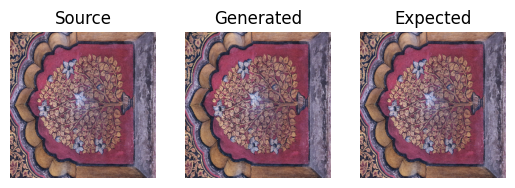

In [ ]:
# https://youtu.be/6pUSZgPJ3Yg
"""
Satellite image to maps image translation ​using Pix2Pix GAN

Data from: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Also find other datasets here: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/
"""

from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from glob import glob
# load all images in a directory into memory
def load_images(path=dataset_path, size=(256,256)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		sat_img = load_img(path + filename, target_size=size)
		# convert to numpy array
		sat_img = img_to_array(sat_img)
		map_img = load_img(path.replace('album-org', 'album-gt') + filename, target_size=size)
		# convert to numpy array
		map_img = img_to_array(map_img)
		# split into satellite and map
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]


# load dataset
[src_images, tar_images] = load_images()
print('Loaded: ', src_images.shape, tar_images.shape)


n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

#######################################

# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=2)
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

#################################################

#Test trained model on a few images...

from keras.models import load_model
from numpy.random import randint
model = load_model('model_000300.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()



[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [ ]:
#Test trained model on a few images...

from keras.models import load_model
from numpy.random import randint
model = load_model('/content/model_000300.h5', compile=False)

In [ ]:
from glob import glob
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage import io, metrics
import numpy as np

psnr = []
ssim = []
mse = []
size = (256, 256)
test_images = glob('/content/drive/MyDrive/muraldataset/album-org/*.jpg')
for image in test_images:
  src_img = load_img(image, target_size=size)
  src_img = img_to_array(src_img)
  src_img = (src_img - 127.5) / 127.5

  exp_img = load_img(image.replace('album-org', 'album-gt'), target_size=size)
  exp_img = img_to_array(exp_img)
  exp_img = (exp_img - 127.5) / 127.5

  gen_image = model.predict(src_img.reshape(1,256,256,3))

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=200)

  ax[0].imshow(src_img)
  ax[0].set_title("Input image")

  ax[1].imshow(exp_img)
  ax[1].set_title("Expected image")

  ax[2].imshow(gen_image[0])
  ax[2].set_title("Generated image")

  psnr.append(metrics.peak_signal_noise_ratio(gen_image[0], exp_img))
  mse.append(metrics.mean_squared_error(gen_image[0], exp_img))
  ssim.append(metrics.structural_similarity(gen_image[0], exp_img, multichannel=True))

# Print the result
print('PSNR:', np.mean(psnr))
print('MSE:', np.mean(mse))
print('SSIM:', np.mean(ssim))


PSNR: nan
MSE: nan
SSIM: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
